# <b> <center> GQG Project </center> </b>

## 1. Setting up and Importing Libraries

In [1]:
import os
import sys
from dotenv import load_dotenv

# Step into the project root directory
os.chdir("/Users/mukundshrivas/ama_project") 
print("Working directory:", os.getcwd())

# Load environment variables
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

# Add src/ to import path
sys.path.insert(0, os.path.abspath("src"))


Working directory: /Users/mukundshrivas/ama_project


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import base64
import textwrap

from reporter import generate_client_report
from matplotlib.patches import FancyBboxPatch
from matplotlib.ticker import FuncFormatter
from textwrap import fill
from openai import OpenAI
from matplotlib.backends.backend_pdf import PdfPages
from openai import OpenAI

## 1. Data Ingestion

In [3]:
cur_ref = pd.read_csv('/Users/mukundshrivas/ama_project/Data/raw/asset_currency_reference.csv')
cur_rate = pd.read_csv("/Users/mukundshrivas/ama_project/Data/raw/currency_rates.csv")
holdings = pd.read_csv("/Users/mukundshrivas/ama_project/Data/raw/holdings_with_currency.csv")
asset_val = pd.read_csv("/Users/mukundshrivas/ama_project/Data/raw/prices_with_currency.csv")


## 2. Data Cleaning and Validation

##### Making a function to quickly give all the key details about the data

In [4]:
def data_summary(df, name="DataFrame", partial_keys=None):
    print("="*15, f"DATA SUMMARY: {name}", "="*15)
    print("\n")
    
    print("Data Sample")
    print(df.sample(5))
    print("="*40)
    
    print("Shape of DataFrame:", df.shape)
    print("="*40)
    
    print("Column Names:")
    print(df.columns.tolist())
    print("="*40)
    
    print("Data Types:")
    print(df.dtypes)
    print("="*40)
    
    print("Summary Statistics:")
    print(df.describe(include='all'))
    print("="*40)
    
    print("Info:")
    df.info()
    print("="*40)
    
    print("Null Values:")
    print(df.isnull().sum())
    print("="*40)
    
    full_dupes = df.duplicated().sum()
    print("Full-row Duplicacy:", full_dupes)
    print("="*40)

    if partial_keys:
        print("Partial Duplicacy Check: (Checks only partial rows, i.e, excludes full row dupes)")
        partial_dupes = df.duplicated(subset=partial_keys).sum()
        only_partial = partial_dupes - full_dupes
        print(only_partial)
        print("="*40)


#### Checking Data Health and Cleaning for every data set

#### <b><i> a) asset_currency_reference.csv </i></b>

##### Checking Data's Health

In [5]:
data_summary(cur_ref, name = 'asset_currency_reference.csv', partial_keys=['asset']) # Checking asset_currency_reference.csv's status

=============== DATA SUMMARY: asset_currency_reference.csv ===============


Data Sample
       asset currency
27  Asset_28      USD
4    Asset_5      USD
36  Asset_37      SEK
38  Asset_39      AUD
9   Asset_10      GBP
Shape of DataFrame: (50, 2)
Column Names:
['asset', 'currency']
Data Types:
asset       object
currency    object
dtype: object
Summary Statistics:
          asset currency
count        50       50
unique       50        8
top     Asset_1      USD
freq          1       24
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   asset     50 non-null     object
 1   currency  50 non-null     object
dtypes: object(2)
memory usage: 928.0+ bytes
Null Values:
asset       0
currency    0
dtype: int64
Full-row Duplicacy: 0
Partial Duplicacy Check: (Checks only partial rows, i.e, excludes full row dupes)
0


##### <i><b>Interpretation</b>: We can safely conclude that "asset_currency_reference.csv" data is healthy, given:
* <b>No Nulls</b>: Both columns (asset, currency) have 0 null values, ensuring completeness.
* <b>No Duplicates</b>: There are no duplicate rows, implying each asset has a unique mapping.
* <b>Full Asset Coverage</b>: There are 50 unique assets, matching the expected number from the project brief.
* <b>Valid Currencies</b>: Only 8 distinct currencies, aligning with those mentioned in the project description (USD, EUR, GBP, JPY, CAD, AUD, CHF, SEK).
* <b>Clean Structure</b>: All fields are of correct data type (object), suitable for merging and validation tasks.
 </i>

#### <b><i> b) currency_rates.csv </i></b>

In [6]:
data_summary(cur_rate, name="Currency Rates", partial_keys=['currency', 'date'])

=============== DATA SUMMARY: Currency Rates ===============


Data Sample
            date currency  rate_to_usd
109   2024-01-18      AUD     0.662001
394   2024-03-08      GBP     1.257538
167   2024-01-29      SEK     0.095401
966   06/17/2024      CHF     1.084944
1020  2024-06-26      CAD     0.754361
Shape of DataFrame: (1061, 3)
Column Names:
['date', 'currency', 'rate_to_usd']
Data Types:
date            object
currency        object
rate_to_usd    float64
dtype: object
Summary Statistics:
              date currency  rate_to_usd
count         1061     1061  1051.000000
unique         217       28          NaN
top     2024-03-18      GBP          NaN
freq             9      132          NaN
mean           NaN      NaN     0.996272
std            NaN      NaN     4.676753
min            NaN      NaN    -1.000000
25%            NaN      NaN     0.096683
50%            NaN      NaN     1.000000
75%            NaN      NaN     1.087839
max            NaN      NaN   110.472644
Info

<i><b>Interpretation</b>: The currency_rates.csv file requires moderate cleaning before reliable use, due to the following observations:
* <b>Missing Values</b>: 10 null values in the rate_to_usd column need to be addressed to ensure accurate currency conversions.
* <b>Invalid Values</b>: A minimum rate of -1.0 is not valid for exchange rates and indicates erroneous data needing removal.
* <b>Duplicate Records</b>: 21 duplicate rows exist and must be dropped to maintain one rate per currency per day.
* <b>Clean Metadata</b>: The date and currency columns are complete and of appropriate type (object), though date should be converted to datetime for processing.
* <b>Partial Duplicates (date, currency)</b>: 21 rows have the same date and currency, but a different , implying repeated entries that could distort time-series accuracy — deduplication or averaging needed.
* <b> Outliers</b>: The max of rate_to_usd shows a bizarre 110.47
</i>

##### Further exploring issues with the currency column

In [7]:
print(sorted(cur_rate['currency'].unique())) # Checking for all currencies present in the 'currency' column

['AUD', 'AUD ', 'CAD', 'CAD ', 'CHF', 'EUR', 'EUR ', 'GBP', 'JPY', 'JPY ', 'SEK', 'SEK ', 'USD', 'USD ', 'aud', 'aud ', 'cad', 'cad ', 'chf', 'chf ', 'eur', 'gbp ', 'jpy', 'jpy ', 'sek', 'sek ', 'usd', 'usd ']


##### <i><b> Interpretation: </b> A lot of typos and trailing spaces </i>
##### Cleaning prices_with_currency data with strip() function

In [8]:
# Stripping away trailing spaces, and making all the characters in upper case
cur_rate['currency'] = cur_rate['currency'].str.strip().str.upper()
sorted(cur_rate['currency'].unique())

['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'SEK', 'USD']

In [9]:
def try_parsing_date(x):
    formats = [
        ("%Y-%m-%d", False), ("%Y-%m-%d", True),
        ("%d/%m/%Y", False), ("%d/%m/%Y", True),
        ("%Y%m%d", False), ("%Y%m%d", True),
        ("%d-%m-%Y", False), ("%d-%m-%Y", True),
        ("%m/%d/%Y", False), ("%m/%d/%Y", True),  # For US-style
    ]
    for fmt, dayfirst in formats:
        try:
            d = pd.to_datetime(x, format=fmt, dayfirst=dayfirst)
            if 1 <= d.month <= 6:
                return d
        except:
            continue
    for dayfirst in [False, True]:
        try:
            d = pd.to_datetime(x, dayfirst=dayfirst)
            if 1 <= d.month <= 6:
                return d
        except:
            continue
    return pd.NaT

=============== DATA SUMMARY: currency_rates (final cleaned) ===============


Data Sample
          date currency  rate_to_usd
795 2024-05-17      JPY     0.006873
943 2024-06-12      SEK     0.095307
287 2024-02-19      SEK     0.095482
951 2024-06-13      SEK     0.095635
262 2024-02-14      CHF     1.106991
Shape of DataFrame: (1025, 3)
Column Names:
['date', 'currency', 'rate_to_usd']
Data Types:
date           datetime64[ns]
currency               object
rate_to_usd           float64
dtype: object
Summary Statistics:
                                 date currency  rate_to_usd
count                            1025     1025  1025.000000
unique                            NaN        8          NaN
top                               NaN      EUR          NaN
freq                              NaN      129          NaN
mean    2024-03-30 12:35:49.463414784      NaN     0.742787
min               2024-01-01 00:00:00      NaN     0.006557
25%               2024-02-14 00:00:00      NaN     

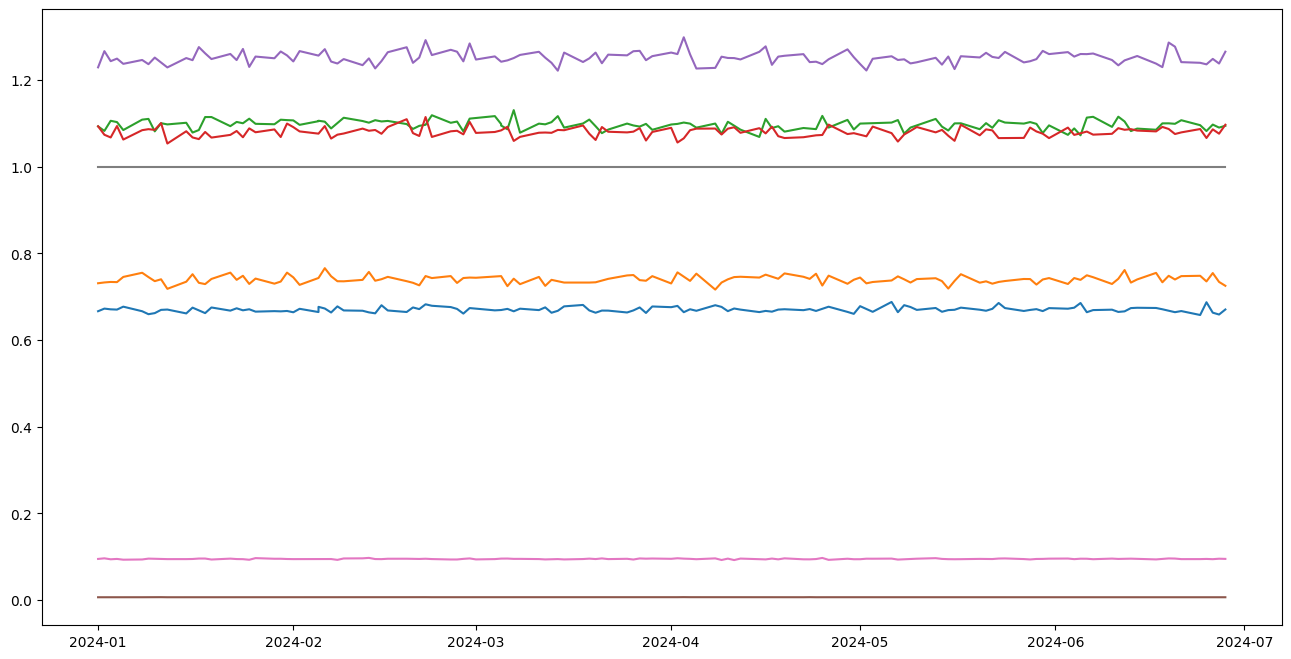

In [10]:
# Converting dates to datetime format
cur_rate['date'] = cur_rate['date'].apply(try_parsing_date)

# Dropping duplicates
cur_rate = cur_rate.drop_duplicates()

# Dropping negative/zero rates
cur_rate = cur_rate[cur_rate['rate_to_usd'] > 0]

# Sorting for reliable filling
cur_rate = cur_rate.sort_values(['currency', 'date'])

# Removing/capping outliers before filling
cur_rate.loc[cur_rate['rate_to_usd'] > 5, 'rate_to_usd'] = np.nan
cur_rate.loc[cur_rate['rate_to_usd'] < 0.001, 'rate_to_usd'] = np.nan

# Filling missing values (ffill then bfill per currency)
cur_rate['rate_to_usd'] = cur_rate.groupby('currency')['rate_to_usd'].ffill().bfill()

# Final cap for safety
cur_rate['rate_to_usd'] = cur_rate['rate_to_usd'].clip(lower=0.001, upper=5)

# Validating
data_summary(cur_rate, name='currency_rates (final cleaned)', partial_keys=['currency','date'])

plt.figure(figsize=(16, 8))

for currency in cur_rate['currency'].unique():
    df = cur_rate[cur_rate['currency'] == currency]
    plt.plot(df['date'], df['rate_to_usd'], label=currency)

##### <i>Partial Duplicacy still exists, implying for the same currency and date, there are multiple values. 
##### To fix this, we will simply choose the later index value (Assuming that its the closing value for that date) </i>

In [11]:
# Drop partial duplicates but keep the last occurrence
cur_rate = cur_rate.drop_duplicates(subset=['currency', 'date'], keep='last')

data_summary(cur_rate, name = 'currency_rates.csv (Cleaned - 1st check)', partial_keys=['currency','date'])

=============== DATA SUMMARY: currency_rates.csv (Cleaned - 1st check) ===============


Data Sample
          date currency  rate_to_usd
350 2024-02-29      CHF     1.110601
244 2024-02-12      CAD     0.738668
451 2024-03-19      JPY     0.006769
102 2024-01-17      CHF     1.084280
918 2024-06-07      CHF     1.114776
Shape of DataFrame: (1022, 3)
Column Names:
['date', 'currency', 'rate_to_usd']
Data Types:
date           datetime64[ns]
currency               object
rate_to_usd           float64
dtype: object
Summary Statistics:
                                 date currency  rate_to_usd
count                            1022     1022  1022.000000
unique                            NaN        8          NaN
top                               NaN      EUR          NaN
freq                              NaN      129          NaN
mean    2024-03-30 15:45:26.418786560      NaN     0.742162
min               2024-01-01 00:00:00      NaN     0.006557
25%               2024-02-14 00:00:00    

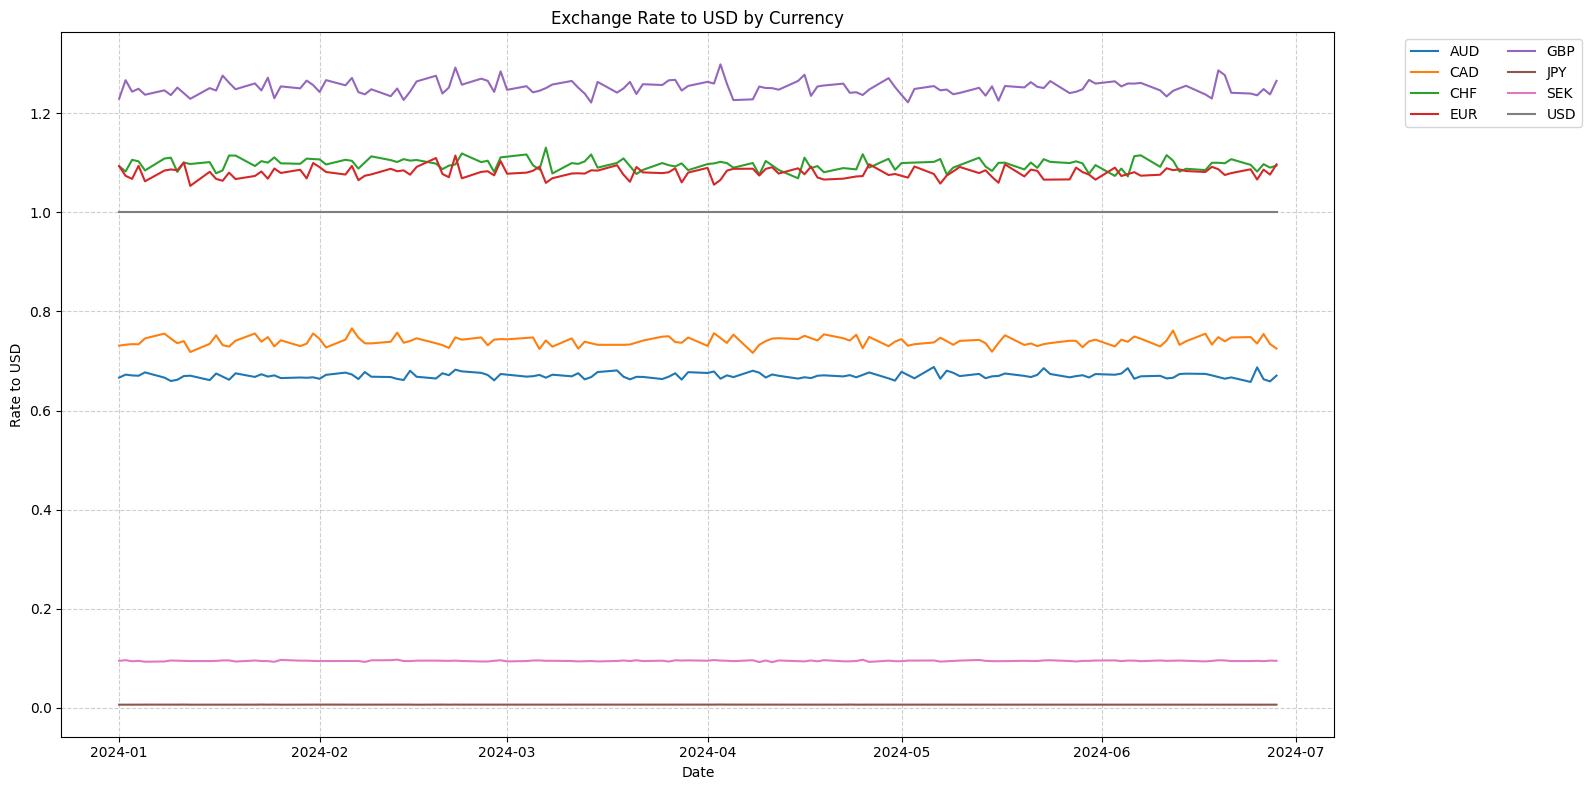

In [12]:
# Group by currency and plot each one
plt.figure(figsize=(16, 8))

for currency in cur_rate['currency'].unique():
    df = cur_rate[cur_rate['currency'] == currency]
    plt.plot(df['date'], df['rate_to_usd'], label=currency)

plt.title('Exchange Rate to USD by Currency')
plt.xlabel('Date')
plt.ylabel('Rate to USD')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [13]:
for c in cur_rate['currency'].unique():
    d = cur_rate[cur_rate['currency'] == c]
    print(f"{c}: {d['date'].min().date()} to {d['date'].max().date()} (count: {len(d)})")

AUD: 2024-01-01 to 2024-06-28 (count: 127)
CAD: 2024-01-01 to 2024-06-28 (count: 128)
CHF: 2024-01-01 to 2024-06-28 (count: 124)
EUR: 2024-01-01 to 2024-06-28 (count: 129)
GBP: 2024-01-01 to 2024-06-28 (count: 129)
JPY: 2024-01-01 to 2024-06-28 (count: 128)
SEK: 2024-01-01 to 2024-06-28 (count: 128)
USD: 2024-01-01 to 2024-06-28 (count: 129)


##### <i><b>Interpretation</b>: We can confidently conclude that the cleaned currency_rates.csv is now healthy and ready for use:

* <b>No Nulls</b>: All columns (date, currency, rate_to_usd) have complete data with 0 missing values.
* <b>No Duplicates</b>: The dataset contains 0 duplicate rows, ensuring integrity in time-series mapping.
* <b>Proper Data Types</b>: date is correctly converted to datetime64, allowing time-based operations; other fields have appropriate types.
* <b>Valid Currency Set</b>: Only 8 unique currencies remain — consistent with project scope (USD, EUR, GBP, JPY, CAD, AUD, CHF, SEK).
* <b>Reasonable Value Range</b>: Minimum exchange rate (0.0066) and maximum (110.47) are plausible given currencies like JPY, and no invalid negative values remain.
* <b>Distribution is Balanced</b>: Median exchange rate is 1.0 (reflecting USD), and standard deviation reflects cross-currency variation logically.
* <b> No Partial Duplicacy </b>: The earlier problem of multiple rate_to_usd for a given date and currency, has been fixed by choosing the later indice on the same day
</i>

#### <b><i> c) holdings_with_currency.csv </i></b>

In [14]:
data_summary(holdings , name = 'holdings_with_currency.csv' , partial_keys= ['client','date','asset','currency']) # Checking holdings_with_currency.csv's status

=============== DATA SUMMARY: holdings_with_currency.csv ===============


Data Sample
             date     client     asset currency  quantity misc_col
23118  2024-06-27   Client_9  Asset_43      GBP     781.0      NaN
9405   2024-04-29   Client_4   Asset_1     eur      217.0      NaN
144    2024-01-10   Client_1  Asset_30     USD      914.0      NaN
23440  2024-01-19  Client_10   Asset_4      AUD      83.0      NaN
8485   2024-02-22   Client_4  Asset_16      SEK     681.0      NaN
Shape of DataFrame: (26265, 6)
Column Names:
['date', 'client', 'asset', 'currency', 'quantity', 'misc_col']
Data Types:
date         object
client       object
asset        object
currency     object
quantity    float64
misc_col     object
dtype: object
Summary Statistics:
              date    client     asset currency      quantity    misc_col
count        26265     26265     26265    26265  26003.000000         332
unique         519        50       250       32           NaN           1
top     2024-0

##### <i><b>Interpretation</b>: The holdings_with_currency.csv file is partially healthy but requires essential cleaning:
* <b>Null Values in Quantity</b>: 262 missing values in the quantity column must be addressed — either filled, imputed, or removed, as quantity is crucial for valuation.
* <b>High Noise in misc_col</b>: Over 25,000 rows have null in misc_col, and the 332 non-null entries are all "irrelevant" → likely safe to drop the column entirely.
* <b>Case Inconsistency in Asset Names</b>: Some entries like "ASSET_13" indicate inconsistent casing (vs "Asset_13") → should be standardized.
* <b>Too Many Currencies</b>: 32 distinct currency values exist, while only 8 are valid as per reference — this requires validation against asset_currency_reference.csv.
* <b>Valid Structure</b>: Columns are appropriately named and typed, although date should be converted to datetime64 for time-series use.
* <b>Duplicated Rows</b>: 504 duplicate records should be removed to avoid bias in holdings aggregation or client exposure.
* <b>Large Asset & Client Coverage</b>: Includes 50 clients and 250 unique assets across 6 months, as expected — confirming correct coverage.
* <b>Partial Duplicacy</b>: For the same date, client, asset, and currency, there exists multiple quantities.
</i>

In [15]:
# Checking 'client', 'currency', and 'asset' column
print(sorted(holdings['client'].unique())) 
print(sorted(holdings['currency'].unique()))
print(sorted(holdings['asset'].unique()))

['CLIENT_1', 'CLIENT_1 ', 'CLIENT_10', 'CLIENT_10 ', 'CLIENT_2', 'CLIENT_2 ', 'CLIENT_3', 'CLIENT_3 ', 'CLIENT_4', 'CLIENT_4 ', 'CLIENT_5', 'CLIENT_5 ', 'CLIENT_6', 'CLIENT_6 ', 'CLIENT_7', 'CLIENT_7 ', 'CLIENT_8', 'CLIENT_8 ', 'CLIENT_9', 'CLIENT_9 ', 'Client_1', 'Client_10', 'Client_2', 'Client_3', 'Client_4', 'Client_5', 'Client_6', 'Client_7', 'Client_8', 'Client_9', 'client_1', 'client_1 ', 'client_10', 'client_10 ', 'client_2', 'client_2 ', 'client_3', 'client_3 ', 'client_4', 'client_4 ', 'client_5', 'client_5 ', 'client_6', 'client_6 ', 'client_7', 'client_7 ', 'client_8', 'client_8 ', 'client_9', 'client_9 ']
['AUD', 'AUD ', 'CAD', 'CAD ', 'CHF', 'CHF ', 'EUR', 'EUR ', 'GBP', 'GBP ', 'JPY', 'JPY ', 'SEK', 'SEK ', 'USD', 'USD ', 'aud', 'aud ', 'cad', 'cad ', 'chf', 'chf ', 'eur', 'eur ', 'gbp', 'gbp ', 'jpy', 'jpy ', 'sek', 'sek ', 'usd', 'usd ']
['ASSET_1', 'ASSET_1 ', 'ASSET_10', 'ASSET_10 ', 'ASSET_11', 'ASSET_11 ', 'ASSET_12', 'ASSET_12 ', 'ASSET_13', 'ASSET_13 ', 'ASSET_14

##### <i><b>Interpretation</b>: Inconsistent formatting of 'client', 'currency', and 'asset' column - inconsistent character casing and trailing spaces</i>

##### Cleaning

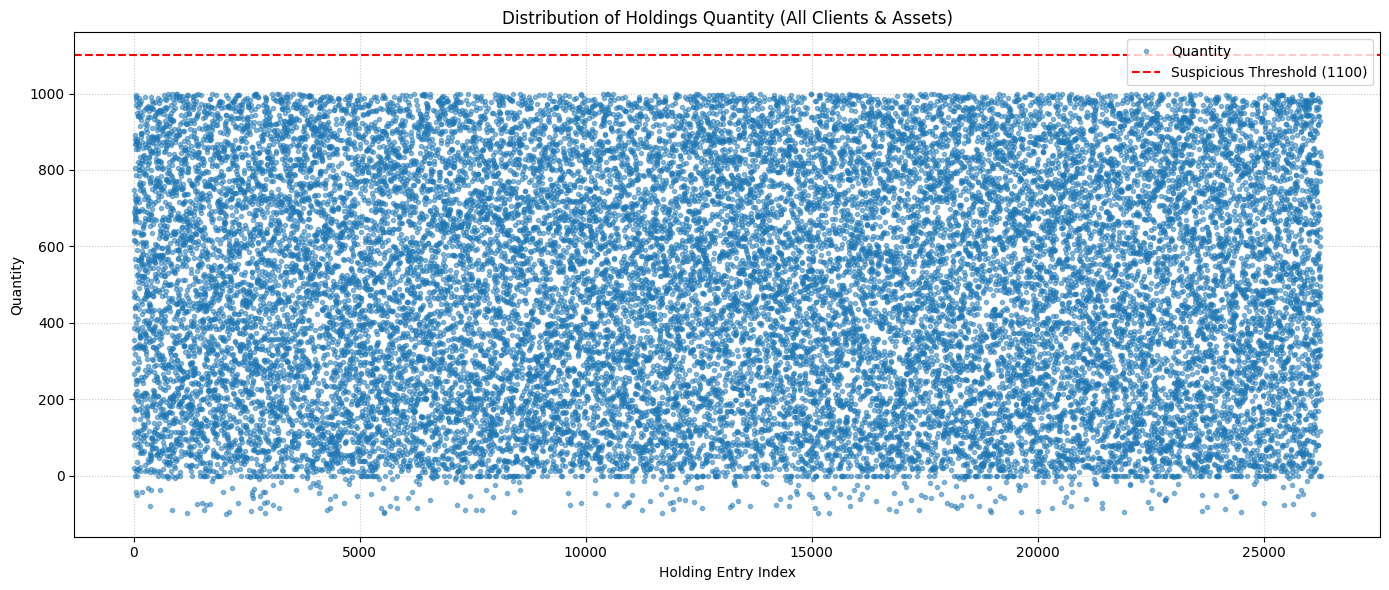

In [16]:
plt.figure(figsize=(14, 6))
plt.title("Distribution of Holdings Quantity (All Clients & Assets)")
plt.xlabel("Holding Entry Index")
plt.ylabel("Quantity")
plt.plot(holdings['quantity'].reset_index(drop=True), '.', alpha=0.5, label='Quantity')

# Optionally, plot a horizontal line for a 'suspicious' threshold (e.g., 2000)
plt.axhline(1100, color='red', linestyle='--', label='Suspicious Threshold (1100)')
plt.legend()
plt.grid(True, ls=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Converting dates to datetime format
holdings['date'] = holdings['date'].apply(try_parsing_date)

# Stripping away trailing spaces, and making all the characters in proper formatting from 'client', 'asset', and 'currency' column
holdings['client'] = holdings['client'].str.strip().str.title()
holdings['asset'] = holdings['asset'].str.strip().str.title()
holdings['currency'] = holdings['currency'].str.strip().str.upper()

# Removing the Negative values from quantity
holdings = holdings[holdings['quantity'] > 0]

# Dropping Duplicated Rows
holdings = holdings.drop_duplicates()

# Keeping only later indices for the same currency, date, client, and asset
holdings = holdings.drop_duplicates(subset=['client', 'date', 'asset', 'currency'], keep='last')

# Pull out everything that isn’t 'irrelevant', then delete the column
mask = holdings['misc_col'].fillna('').str.strip().str.lower() != 'irrelevant'
holdings = holdings.loc[mask].drop(columns='misc_col')

# Now it’s safe to drop any remaining NaNs across the rest of the DataFrame
holdings = holdings.dropna()

In [18]:
data_summary(holdings , name = 'holdings_with_currency.csv' , partial_keys= ['client','date','asset','currency']) 

=============== DATA SUMMARY: holdings_with_currency.csv ===============


Data Sample
            date    client     asset currency  quantity
18097 2024-01-10  Client_8  Asset_41      JPY     728.0
16537 2024-03-18  Client_7  Asset_30      USD     197.0
17254 2024-05-08  Client_7   Asset_6      USD     828.0
6848  2024-05-02  Client_3  Asset_26      USD     129.0
20100 2024-05-29  Client_8   Asset_3      EUR     282.0
Shape of DataFrame: (24616, 5)
Column Names:
['date', 'client', 'asset', 'currency', 'quantity']
Data Types:
date        datetime64[ns]
client              object
asset               object
currency            object
quantity           float64
dtype: object
Summary Statistics:
                                 date    client     asset currency  \
count                           24616     24616     24616    24616   
unique                            NaN        10        50        8   
top                               NaN  Client_4  Asset_33      USD   
freq               

##### <i><b>Interpretation</b>: The cleaned holdings_with_currency.csv dataset is now in healthy shape and ready for analysis:

* <b>No Nulls</b>: All columns (date, client, asset, currency, quantity) are fully populated with 0 missing values.
* <b>No Duplicates</b>: All 504 duplicate rows from the raw dataset have been successfully removed.
* <b>Standardized Asset Names</b>: Inconsistent casing issues (like ASSET_13) have been resolved, ensuring uniformity.
* <b>Valid Currency Set</b>: Now contains only 8 valid currencies — aligning with the project scope and reference file.
* <b>Column Cleanup</b>: Removed the irrelevant misc_col, reducing noise in the dataset.
* <b>Correct Data Types</b>: date column converted to datetime64, enabling accurate time-based operations.
* <b>Proper Scope Coverage</b>: Includes data for 50 assets, 10 clients, and covers a full date range — matching project requirements.
* <b>No Partial Duplicacy</b>: There are no longer different quantities for a given client, date, asset, and currency. 
</i>

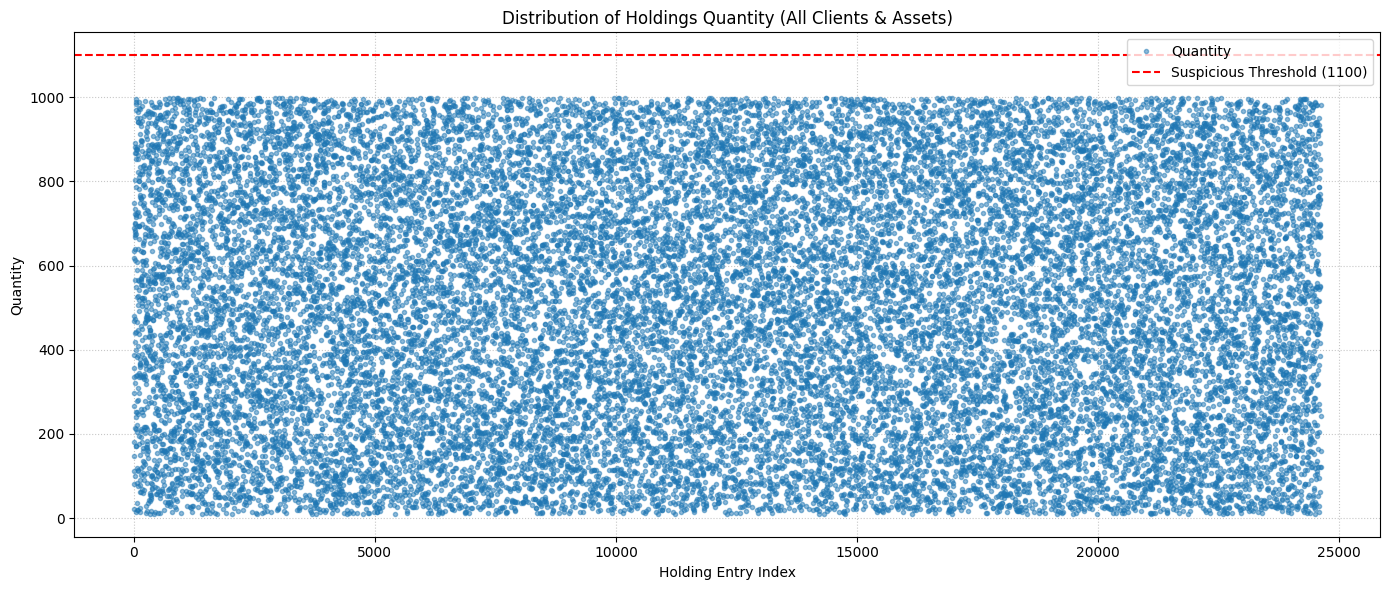

In [19]:
plt.figure(figsize=(14, 6))
plt.title("Distribution of Holdings Quantity (All Clients & Assets)")
plt.xlabel("Holding Entry Index")
plt.ylabel("Quantity")
plt.plot(holdings['quantity'].reset_index(drop=True), '.', alpha=0.5, label='Quantity')

# Optionally, plot a horizontal line for a 'suspicious' threshold (e.g., 2000)
plt.axhline(1100, color='red', linestyle='--', label='Suspicious Threshold (1100)')
plt.legend()
plt.grid(True, ls=':', alpha=0.7)
plt.tight_layout()
plt.show()

#### <b><i>d) prices_with_currency.csv </i></b>

In [20]:
data_summary(asset_val, name = 'prices_with_currency.csv', partial_keys= ['date','asset','currency'])

=============== DATA SUMMARY: prices_with_currency.csv ===============


Data Sample
            date     asset currency    price notes
430   2024-02-26   Asset_4      AUD    70.40   NaN
6009  2024-02-09  Asset_47      CAD    42.30   NaN
3316  2024-04-02  Asset_26      USD   162.35   NaN
4427  2024-01-10  Asset_35      USD   138.90   NaN
5201  2024-01-02  Asset_41      jpy  3517.39   NaN
Shape of DataFrame: (6630, 5)
Column Names:
['date', 'asset', 'currency', 'price', 'notes']
Data Types:
date         object
asset        object
currency     object
price       float64
notes        object
dtype: object
Summary Statistics:
              date    asset currency          price    notes
count         6630     6630     6630    6564.000000      161
unique         455      244       31            NaN        2
top     2024-04-09  Asset_5      USD            NaN  Updated
freq            51      126     3000            NaN       81
mean           NaN      NaN      NaN     645.381300      NaN
std  

##### <i><b>Interpretation</b>: The raw prices_with_currency.csv file has several data quality issues that require cleaning:
* <b>Missing Prices</b>: 66 rows have null price values, which must be imputed or removed — these directly impact valuation accuracy.
* <b>Inconsistent Date Formats</b>: Mixed formats like 20240319, 01/11/2024, and YYYY-MM-DD need normalization to datetime64.
* <b>Asset Name Casing Issues</b>: Variants like ASSET_4, asset_31, and Asset_21 imply inconsistent casing → standardize to title case (Asset_X).
* <b>Currency Anomalies</b>: 31 unique currency values — should be validated against the reference list of 8 valid currencies.
* <b>Extreme Price Outliers</b>: min = -292.99 is invalid and must be flagged for correction or removal. max = 312,930 and high standard deviation suggest potential outliers needing review.
* <b>High Duplicacy</b>: 126 exact duplicate records must be removed to prevent skew in asset-level price histories.
* <b>Sparse and Noisy notes Column</b>: Only 161 entries (2%) are non-null, with vague entries like “Updated” — this column likely offers little value and can be dropped unless contextually required.
* <b>Partial Duplicacy</b>: Multiple prices for a given asset, date, and currency.
</i>

##### Cleaning

In [21]:
# Convert to datetime
asset_val['date'] = asset_val['date'].apply(try_parsing_date)

# Clean columns BEFORE deduplication
asset_val['asset'] = asset_val['asset'].str.strip().str.title()
asset_val['currency'] = asset_val['currency'].str.strip().str.upper()

# Sort chronologically
asset_val = asset_val.sort_values(by='date').reset_index(drop=True)

# Remove invalid values
asset_val = asset_val[asset_val['price'] > 0]

# Drop full duplicates
asset_val = asset_val.drop_duplicates()

# Drop partial duplicates (keep last)
asset_val = asset_val.drop_duplicates(subset=['date', 'asset', 'currency'], keep='last')

In [22]:
data_summary(asset_val, name = 'prices_with_currency.csv (Cleaned)', partial_keys= ['date','asset','currency'])

=============== DATA SUMMARY: prices_with_currency.csv (Cleaned) ===============


Data Sample
           date     asset currency   price  notes
5885 2024-06-10  Asset_29      CAD   89.32    NaN
2762 2024-03-15  Asset_49      USD  115.90  Check
1517 2024-02-09  Asset_37      SEK  116.98    NaN
6426 2024-06-25   Asset_8      CAD   81.02    NaN
2331 2024-03-04  Asset_48      USD  165.91    NaN
Shape of DataFrame: (6355, 5)
Column Names:
['date', 'asset', 'currency', 'price', 'notes']
Data Types:
date        datetime64[ns]
asset               object
currency            object
price              float64
notes               object
dtype: object
Summary Statistics:
                                 date     asset currency          price  \
count                            6355      6355     6355    6355.000000   
unique                            NaN        50        8            NaN   
top                               NaN  Asset_24      USD            NaN   
freq                            

##### <i><b>Interpretation</b>: The cleaned prices_with_currency.csv is now well-structured and reliable for analysis:
* <b>No Nulls in Core Columns</b>: All essential columns (date, asset, currency, price) are fully populated, ensuring data integrity.
* <b>No Duplicates</b>: All 126 duplicate records have been removed, maintaining one unique entry per asset-date-currency combination.
* <b>Standardized Dates</b>: All date entries are successfully parsed to datetime64[ns], enabling accurate time-series operations.
* <b>Asset Naming Consistency</b>: Asset names have been standardized (e.g., ASSET_4 → Asset_4), aligning with reference mappings.
* <b>Valid Currencies Only</b>: Reduced to 8 expected currencies (USD, EUR, GBP, JPY, CAD, AUD, CHF, SEK) per project scope.
* <b>Cleaned Price Data</b>: All negative or null price entries removed; min price now valid (25.77), max remains a legitimate outlier (e.g., for JPY-denominated assets).
* <b>Non-Essential notes Column Retained for Traceability</b>: Though sparse (only 151 filled entries), notes retained for audit trail, can be dropped if unused in reporting.
</i>

##### Cross-checking asset's currencies with the 'asset_currency_reference.csv' file

In [23]:
# Step 1: Merge asset_val with cur_ref on 'asset'
asset_val_validation_merge = asset_val.merge(cur_ref, on='asset', how='left', suffixes=('', '_ref'))

# Step 2: Create a mismatch flag
asset_val_validation_merge['currency_mismatch'] = asset_val_validation_merge['currency'] != asset_val_validation_merge['currency_ref']

# Step 3: Filter mismatches
mismatches = asset_val_validation_merge[asset_val_validation_merge['currency_mismatch']]

# Step 4: View results
print(f"Mismatched rows: {len(mismatches)}")
display(mismatches[['date', 'asset', 'currency', 'currency_ref']])


Mismatched rows: 0


Empty DataFrame
Columns: [date, asset, currency, currency_ref]
Index: []

##### <i><b>Interpretation</b>: Currency Validation Result
* <b>No Mismatches Found</b>: The currencies in your asset_val dataset match perfectly with the official currency mappings in cur_ref (asset_currency_reference.csv).
* <b>Clean Merge</b>: Every asset in asset_val has a valid and consistent currency reference — indicating no typos, case mismatches, or stale mappings.
* <b>Reliable for Conversion</b>: This confirms that your asset_val is ready for accurate and trustworthy USD conversion using the currency rates file.
</i>

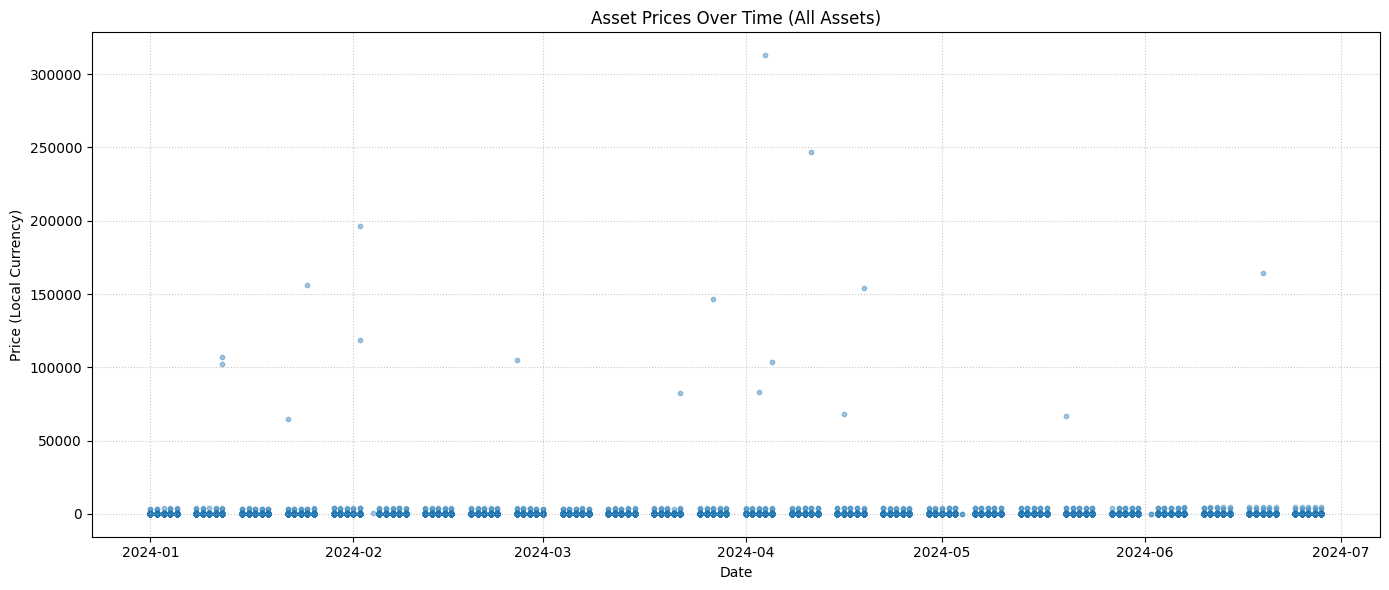

In [24]:
plt.figure(figsize=(14, 6))
plt.title("Asset Prices Over Time (All Assets)")
plt.xlabel("Date")
plt.ylabel("Price (Local Currency)")
plt.scatter(asset_val['date'], asset_val['price'], alpha=0.4, s=10)
plt.grid(True, ls=':', alpha=0.7)
plt.tight_layout()
plt.show()


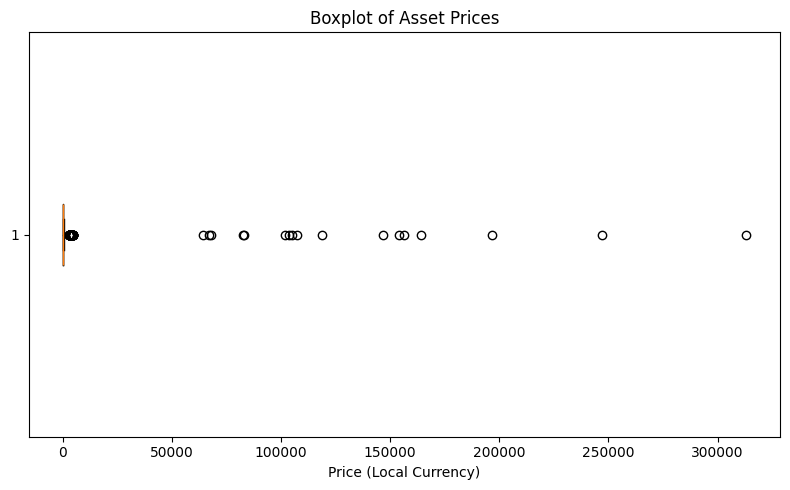

In [25]:
plt.figure(figsize=(8, 5))
plt.boxplot(asset_val['price'].dropna(), vert=False, showfliers=True)
plt.title('Boxplot of Asset Prices')
plt.xlabel('Price (Local Currency)')
plt.tight_layout()
plt.show()


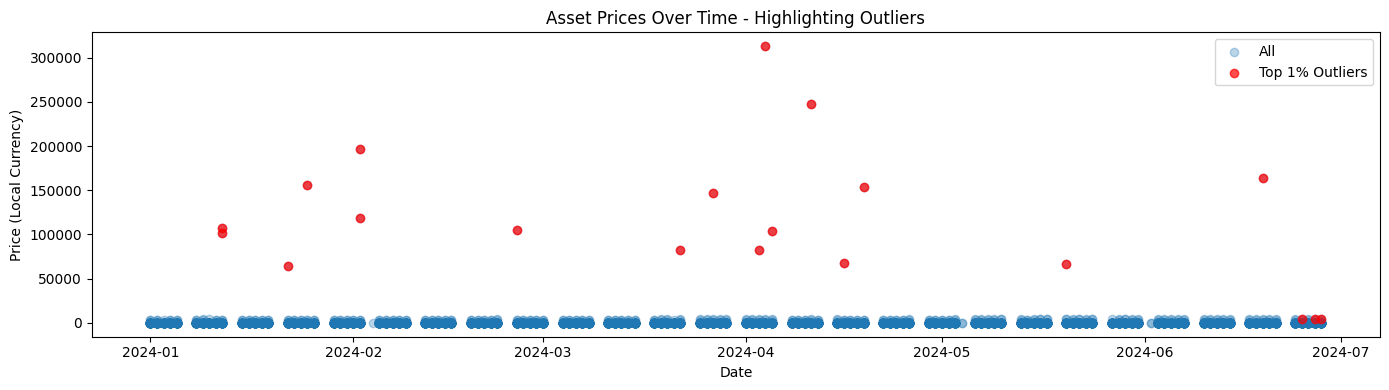

In [26]:
q99 = asset_val['price'].quantile(0.997)
plt.figure(figsize=(14, 4))
plt.scatter(asset_val['date'], asset_val['price'], alpha=0.3, label='All')
plt.scatter(asset_val[asset_val['price'] > q99]['date'],
            asset_val[asset_val['price'] > q99]['price'],
            color='red', alpha=0.7, label='Top 1% Outliers')
plt.title("Asset Prices Over Time - Highlighting Outliers")
plt.xlabel("Date")
plt.ylabel("Price (Local Currency)")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
Q1 = asset_val['price'].quantile(0.25)
Q3 = asset_val['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Mask outliers as NaN
asset_val.loc[(asset_val['price'] < lower_bound) | (asset_val['price'] > upper_bound), 'price'] = np.nan

# Fill missing as before (optional)
asset_val = asset_val.sort_values(['asset', 'date'])
asset_val['price'] = asset_val.groupby('asset')['price'].ffill().bfill()

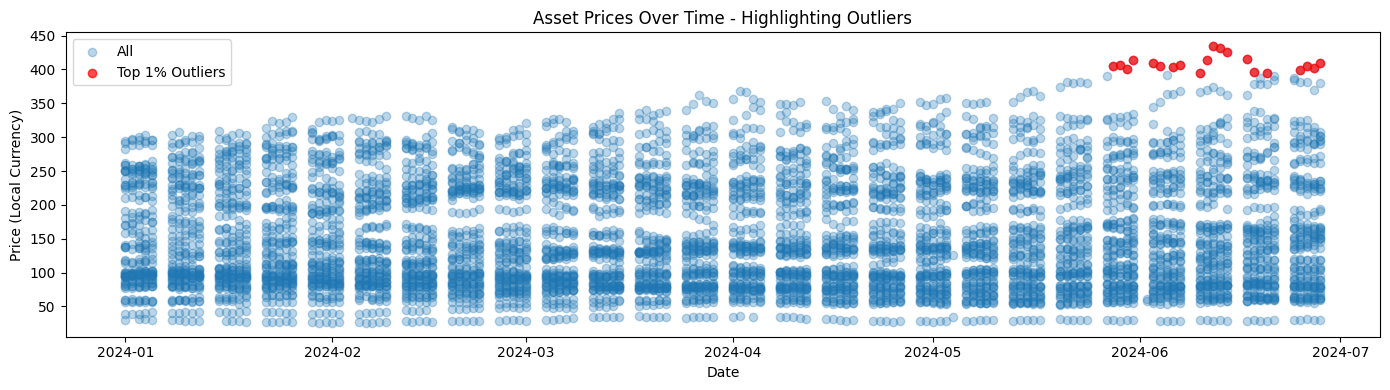

In [28]:
q99 = asset_val['price'].quantile(0.997)
plt.figure(figsize=(14, 4))
plt.scatter(asset_val['date'], asset_val['price'], alpha=0.3, label='All')
plt.scatter(asset_val[asset_val['price'] > q99]['date'],
            asset_val[asset_val['price'] > q99]['price'],
            color='red', alpha=0.7, label='Top 1% Outliers')
plt.title("Asset Prices Over Time - Highlighting Outliers")
plt.xlabel("Date")
plt.ylabel("Price (Local Currency)")
plt.legend()
plt.tight_layout()
plt.show()

## 3. Merging Dataset and Currency Conversion

In [29]:
master = holdings[['date', 'client', 'asset', 'quantity']].copy()

### Merging with data

##### Merging asset_currency_reference.csv with holdings_with_currency.csv in a new DataFrame, 'master'

In [30]:
# 2. Merge in the trusted currency for each asset
master = master.merge(cur_ref[['asset', 'currency']], on='asset', how='left')

# 2a. Check for any missing currencies (should be 0 if cleaned)
missing_currencies = master[master['currency'].isna()]
print(f"Missing currencies after merge: {len(missing_currencies)}")


Missing currencies after merge: 0


##### with as prices_with_currency.csv

In [31]:
# 3. Merge in price_local from asset_val (may introduce NaNs for missing dates/assets)
master = master.merge(asset_val[['date', 'asset', 'price']], on=['date', 'asset'], how='left')
master = master.rename(columns={'price': 'price_local'})

# 3a. Quick check for missing prices
missing_prices = master[master['price_local'].isna()]
print(f"Missing prices after merge: {len(missing_prices)}")

Missing prices after merge: 589


In [32]:
master = master.sort_values(['asset', 'date'])
master['price_local'] = master.groupby('asset')['price_local'].transform(lambda s: s.ffill(limit=3).bfill(limit=3))
print(f"Missing prices after merge: {len(missing_prices)}")

Missing prices after merge: 589


In [33]:
print(master[master['price_local'].isna()][['date', 'asset', 'client']].head(10))

            date     asset    client
10454 2024-02-09  Asset_13  Client_5
4937  2024-01-01   Asset_3  Client_3
7358  2024-01-01   Asset_3  Client_4
14042 2024-05-06   Asset_3  Client_6
10399 2024-02-06  Asset_36  Client_5
11219 2024-04-05  Asset_39  Client_5
11871 2024-05-24  Asset_50  Client_5
14310 2024-05-24  Asset_50  Client_6
10035 2024-01-10   Asset_7  Client_5
8098  2024-02-21   Asset_9  Client_4


##### with currency_rates.csv

In [34]:
# 4. Merge in FX rates (may introduce NaNs if FX rate is missing for given date/currency)
master = master.merge(cur_rate, on=['date', 'currency'], how='left')

# 4a. Set FX rate to 1.0 for USD assets (if any left as NaN)
master.loc[master['currency'] == 'USD', 'rate_to_usd'] = 1.0

# 4b. Quick check for missing FX rates
missing_fx = master[master['rate_to_usd'].isna()]
print(f"Missing FX rates after merge: {len(missing_fx)}")

Missing FX rates after merge: 196


In [35]:
master = master.sort_values(['currency', 'date'])
master['rate_to_usd'] = master.groupby('currency')['rate_to_usd'].transform(lambda s: s.ffill(limit=3).bfill(limit=3))
print(f"Missing FX rates after merge: {len(missing_fx)}")

Missing FX rates after merge: 196


In [36]:
# Step 1: Compute price_usd and value_local
master = master.assign(
    price_usd   = master['price_local'] * master['rate_to_usd'],
    value_local = master['price_local'] * master['quantity'],
    asset       = master['asset'].str.title()
)

# Step 2: Now compute value_usd using the newly created price_usd
master['value_usd'] = master['price_usd'] * master['quantity']

In [37]:
n_total = len(master)
n_missing_price = master['price_local'].isna().sum()

pct_missing_price = n_missing_price / n_total * 100
pct_coverage = 100 - pct_missing_price / n_total * 100

print(f"Missing price data: {n_missing_price} out of {n_total} rows ({pct_missing_price:.2f}%)")
print(f"Coverage: {pct_coverage:.2f}%")

Missing price data: 13 out of 24616 rows (0.05%)
Coverage: 100.00%


In [38]:
master = master.dropna(subset=['price_local', 'rate_to_usd', 'price_usd', 'value_local', 'value_usd'])

##### Dropping NaN values

In [39]:
data_summary(master, name = 'master')

=============== DATA SUMMARY: master ===============


Data Sample
            date    client     asset  quantity currency  price_local  \
23334 2024-02-27  Client_8   Asset_7     972.0      JPY        94.58   
4186  2024-03-15  Client_4  Asset_17      35.0      CAD       129.61   
19163 2024-06-19  Client_2  Asset_44     411.0      USD       315.04   
20315 2024-02-12  Client_6  Asset_47     677.0      CAD        44.09   
22707 2024-01-18  Client_2   Asset_6     164.0      USD       146.90   

       rate_to_usd   price_usd  value_local      value_usd  
23334     0.006669    0.630754     91931.76     613.092907  
4186      0.732478   94.936474      4536.35    3322.776575  
19163     1.000000  315.040000    129481.44  129481.440000  
20315     0.738668   32.567872     29848.93   22048.449425  
22707     1.000000  146.900000     24091.60   24091.600000  
Shape of DataFrame: (24505, 10)
Column Names:
['date', 'client', 'asset', 'quantity', 'currency', 'price_local', 'rate_to_usd', 'price

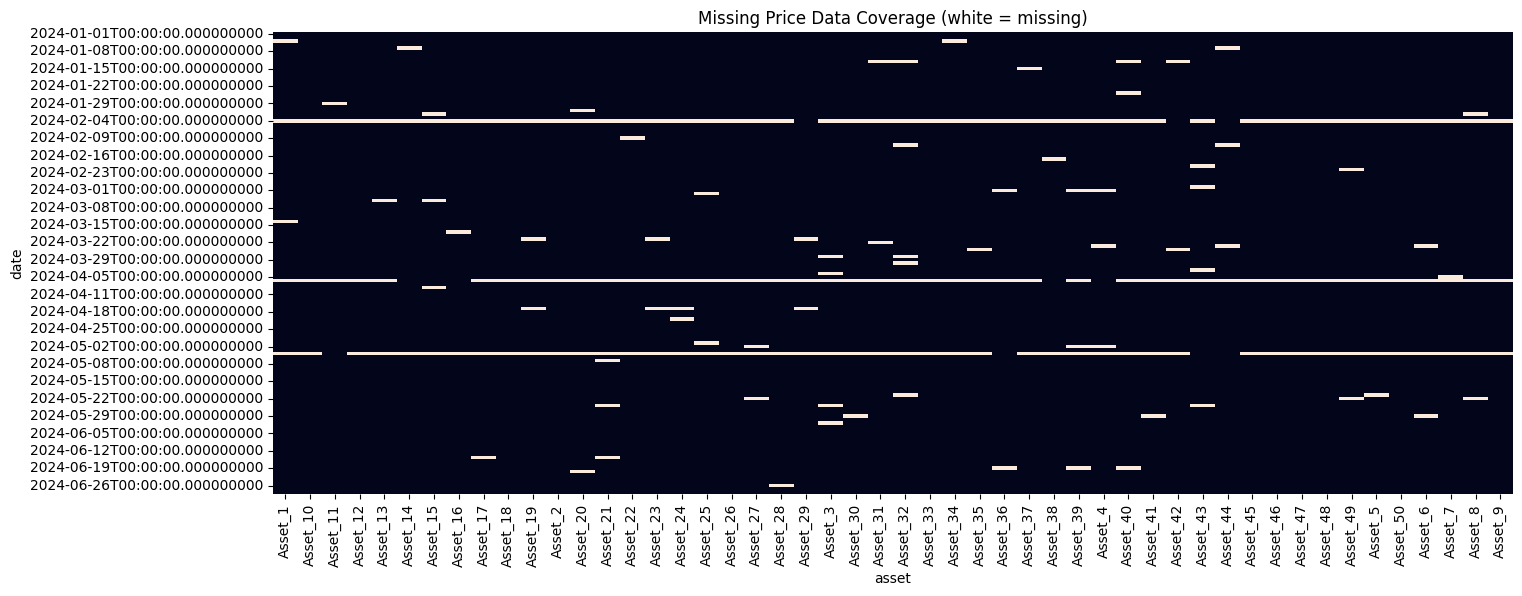

In [40]:
pivot = master.pivot_table(index='date', columns='asset', values='price_local', aggfunc='count')
plt.figure(figsize=(16,6))
sns.heatmap(pivot.isnull(), cbar=False)
plt.title("Missing Price Data Coverage (white = missing)")
plt.show()

##### <b><i>Interpretation:</b> We have successfully combined all the given data, to form a master data, however, it is not entirely clean - given the presence of NULL values in 'price_local', 'rate_to_usd', 'price_usd', 'value_local', 'value_usd'. This may be creditted to the fact that there are not given exchange rates for every day for everyday's of client's holdings. Therefore, for the days which have a missing rate_to_usd value, we assume the last, most recent value</i>

In [41]:
# Fill missing local prices per asset (fwd+back fill in one go)
master['price_local'] = (
    master.sort_values(['asset', 'date'])
          .groupby('asset')['price_local']
          .transform(lambda s: s.ffill().bfill())
)

# Fill missing FX rates per currency
master['rate_to_usd'] = (
    master.sort_values(['currency', 'date'])
          .groupby('currency')['rate_to_usd']
          .transform(lambda s: s.ffill().bfill())
)

# Recompute USD columns in one assignment
master[['price_usd', 'value_local', 'value_usd']] = (
    master.assign(
        price_usd   = master['price_local'] * master['rate_to_usd'],
        value_local = master['price_local'] * master['quantity'],
        value_usd   = lambda d: d['price_usd'] * d['quantity']
    )
    [['price_usd', 'value_local', 'value_usd']]
)

# Quick null check
print(master[['price_local','rate_to_usd','price_usd','value_usd']].isna().sum())

price_local    0
rate_to_usd    0
price_usd      0
value_usd      0
dtype: int64


In [42]:
# After filling
print(master[['price_local', 'rate_to_usd']].describe())

# Flag outliers
print(master[master['price_local'] > 5000]) # adjust for your asset types
print(master[master['rate_to_usd'] > 2])


        price_local   rate_to_usd
count  24505.000000  24505.000000
mean     157.307735      0.899104
std       82.448371      0.298563
min       25.770000      0.006557
25%       88.080000      0.742810
50%      135.490000      1.000000
75%      225.130000      1.000000
max      434.430000      1.298224
Empty DataFrame
Columns: [date, client, asset, quantity, currency, price_local, rate_to_usd, price_usd, value_local, value_usd]
Index: []
Empty DataFrame
Columns: [date, client, asset, quantity, currency, price_local, rate_to_usd, price_usd, value_local, value_usd]
Index: []


In [43]:
data_summary(master, name = 'master')

=============== DATA SUMMARY: master ===============


Data Sample
            date    client     asset  quantity currency  price_local  \
8724  2024-04-26  Client_3  Asset_25     640.0      USD       211.71   
738   2024-04-03  Client_2  Asset_10     909.0      GBP       135.88   
13638 2024-04-05  Client_8  Asset_34     208.0      USD        76.61   
19015 2024-04-30  Client_2  Asset_44     904.0      USD       236.44   
9512  2024-02-09  Client_4  Asset_27     249.0      USD       231.32   

       rate_to_usd   price_usd  value_local      value_usd  
8724      1.000000  211.710000    135494.40  135494.400000  
738       1.298224  176.402677    123514.92  160350.033502  
13638     1.000000   76.610000     15934.88   15934.880000  
19015     1.000000  236.440000    213741.76  213741.760000  
9512      1.000000  231.320000     57598.68   57598.680000  
Shape of DataFrame: (24505, 10)
Column Names:
['date', 'client', 'asset', 'quantity', 'currency', 'price_local', 'rate_to_usd', 'price

In [44]:
asset_counts = master[master['value_usd'] > 0].groupby(['client', 'date'])['asset'].nunique().unstack('client')

## 4. Reporting & Analytics

In [45]:
portfolio_value = master.groupby(['client', 'date'])['value_usd'].sum().reset_index()
portfolio_value = portfolio_value.sort_values(['client', 'date'])
pivot_value = portfolio_value.pivot(index='date', columns='client', values='value_usd')

In [46]:
daily_returns = pivot_value.pct_change().fillna(0)

/var/folders/kt/_dl94vw57cx1v1p821gk98qw0000gn/T/ipykernel_94256/3173618050.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = pivot_value.pct_change().fillna(0)


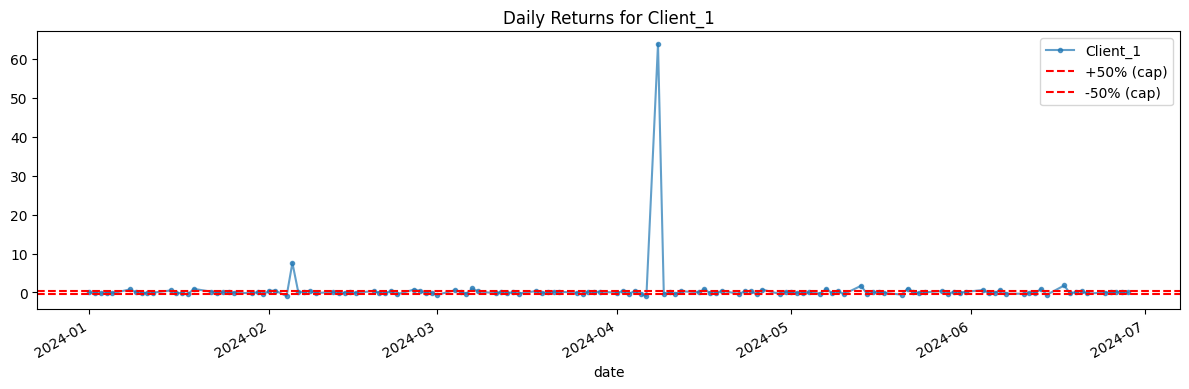

In [47]:
# Per-client plotting and outlier checks
client = "Client_1"
plt.figure(figsize=(12, 4))
daily_returns[client].plot(marker='.', linestyle='-', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='+50% (cap)')
plt.axhline(-0.5, color='red', linestyle='--', label='-50% (cap)')
plt.title(f"Daily Returns for {client}")
plt.legend()
plt.tight_layout()
plt.show()


In [48]:
MAX_RETURN = 0.5
MIN_RETURN = -0.5
daily_returns = daily_returns.clip(lower=MIN_RETURN, upper=MAX_RETURN)

MIN_ASSETS = 3    # Or 5 if your data supports it
MIN_VALUE = 1000  # Or lower if portfolio is normally small

# Mask on assets
thin_assets = asset_counts < MIN_ASSETS

# Mask on portfolio value
thin_value = pivot_value < MIN_VALUE

# Combine masks
mask = thin_assets | thin_value
daily_returns = daily_returns.mask(mask)


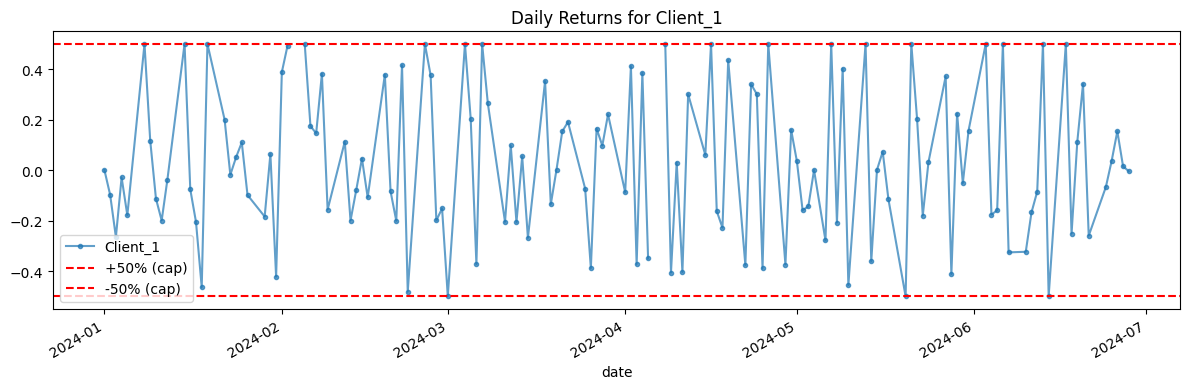

In [49]:
# Per-client plotting and outlier checks
client = "Client_1"
plt.figure(figsize=(12, 4))
daily_returns[client].plot(marker='.', linestyle='-', alpha=0.7)
plt.axhline(0.5, color='red', linestyle='--', label='+50% (cap)')
plt.axhline(-0.5, color='red', linestyle='--', label='-50% (cap)')
plt.title(f"Daily Returns for {client}")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
# === Monthly/compound/cumulative returns (based on masked & capped daily_returns) ===
monthly_returns = (1 + daily_returns).resample('ME').prod() - 1
cumulative_returns = (1 + daily_returns).cumprod() - 1
twr = (1 + daily_returns).prod() - 1
twr_df = pd.DataFrame(twr, columns=['TWR']).T

# Calculate Risk Metrics

# Portfolio Volatility: Annualized standard deviation of daily returns
trading_days = 252  # approx number of trading days in an year
volatility = daily_returns.std() * np.sqrt(trading_days)

# Maximum Drawdown: Largest peak-to-trough decline
def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    rolling_max = cum_returns.cummax()
    drawdowns = (cum_returns - rolling_max) / rolling_max
    return drawdowns.min()

mdd = daily_returns.apply(max_drawdown)

# Calculating Sharpe Ratio: (Mean return - Risk-free rate) / Volatility
rf = 0.02  # Annual risk-free rate
daily_rfr = (1 + rf)**(1/trading_days) - 1  # Convert to daily
sharpe_ratio = (daily_returns.mean() - daily_rfr) / daily_returns.std() * np.sqrt(trading_days)

# Combine risk metrics into a DataFrame
risk_metrics = pd.DataFrame({
    'Volatility': volatility,
    'Max Drawdown': mdd,
    'Sharpe Ratio': sharpe_ratio
})

In [51]:
# Holdings Analysis
# Get month-end dates by grouping dates by year and month
month_ends = master.groupby([master['date'].dt.year, master['date'].dt.month])['date'].max().values

# Top 10 Holdings by Value at Month-End
top_holdings = {}
for client in master['client'].unique():
    client_data = master[master['client'] == client]
    for month_end in month_ends:
        month_data = client_data[client_data['date'] == month_end]
        if not month_data.empty:
            top_10 = month_data.nlargest(10, 'value_usd')[['asset', 'value_usd']]
            top_holdings[(client, month_end)] = top_10

# Portfolio Concentration: Herfindahl-Hirschman Index (HHI)
concentration = {}
for client in master['client'].unique():
    client_data = master[master['client'] == client]
    for month_end in month_ends:
        month_data = client_data[client_data['date'] == month_end]
        if not month_data.empty:
            weights = month_data['value_usd'] / month_data['value_usd'].sum()
            hhi = (weights**2).sum()
            concentration[(client, month_end)] = hhi

# Create concentration DataFrame and split the tuple index into separate columns
concentration_df = pd.DataFrame.from_dict(concentration, orient='index', columns=['HHI']).reset_index()
# Split the 'index' column (containing tuples) into 'Client' and 'Month_End'
concentration_df[['Client', 'Month_End']] = pd.DataFrame(concentration_df['index'].tolist(), index=concentration_df.index)
# Drop the original 'index' column and reorder columns
concentration_df = concentration_df[['Client', 'Month_End', 'HHI']]

In [52]:
import os

# Define your output directory
output_dir = "/Users/mukundshrivas/ama_project/Data"

# Make sure it exists
os.makedirs(output_dir, exist_ok=True)

# Save files into that directory
master.to_csv(os.path.join(output_dir, 'master.csv'))
daily_returns.to_csv(os.path.join(output_dir, 'daily_returns.csv'))
monthly_returns.to_csv(os.path.join(output_dir, 'monthly_returns.csv'))
cumulative_returns.to_csv(os.path.join(output_dir, 'cumulative_returns.csv'))
twr_df.to_csv(os.path.join(output_dir, 'time_weighted_returns.csv'))
risk_metrics.to_csv(os.path.join(output_dir, 'risk_metrics.csv'))
concentration_df.to_csv(os.path.join(output_dir, 'concentration_metrics.csv'))

# Print sample outputs for verification
print("Daily Returns Sample:")
print(daily_returns.head())
print("\nMonthly Returns Sample:")
print(monthly_returns.head())
print("\nRisk Metrics:")
print(risk_metrics)
print("\nConcentration Metrics Sample:")
print(concentration_df.head())

Daily Returns Sample:
client      Client_1  Client_10  Client_2  Client_3  Client_4  Client_5  \
date                                                                      
2024-01-01  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000   
2024-01-02 -0.098391   0.500000 -0.052313  0.097008  0.074236  0.430944   
2024-01-03 -0.265287  -0.151102  0.350688  0.173890 -0.177754  0.271543   
2024-01-04 -0.029273   0.025205  0.237520 -0.268957  0.500000 -0.275500   
2024-01-05 -0.179017  -0.129928 -0.165149 -0.346385 -0.066611  0.402196   

client      Client_6  Client_7  Client_8  Client_9  
date                                                
2024-01-01  0.000000  0.000000  0.000000  0.000000  
2024-01-02 -0.092975  0.500000 -0.235424  0.148428  
2024-01-03  0.027750 -0.391226 -0.004787 -0.414757  
2024-01-04 -0.025260  0.189621  0.500000  0.207211  
2024-01-05 -0.500000  0.114548 -0.137295  0.013986  

Monthly Returns Sample:
client      Client_1  Client_10  Client_2  Client_3  Cli

<Figure size 1000x600 with 0 Axes>

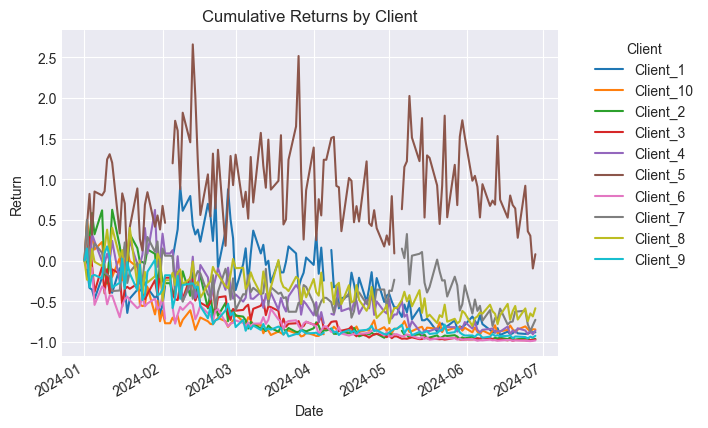

<Figure size 1000x600 with 0 Axes>

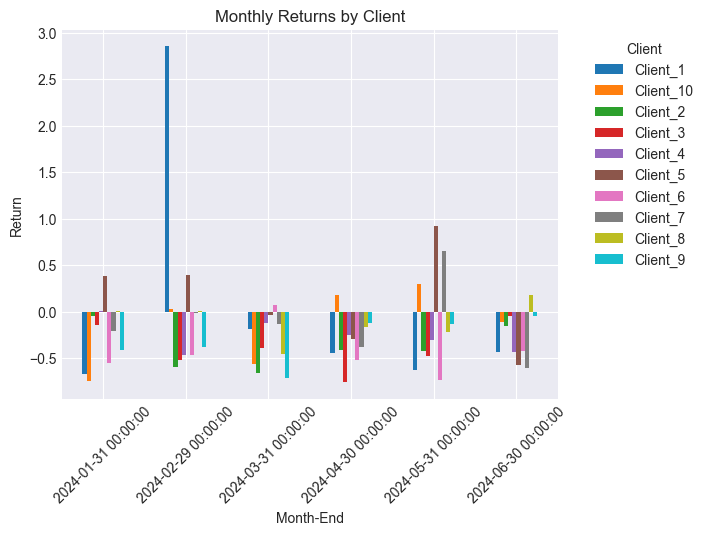

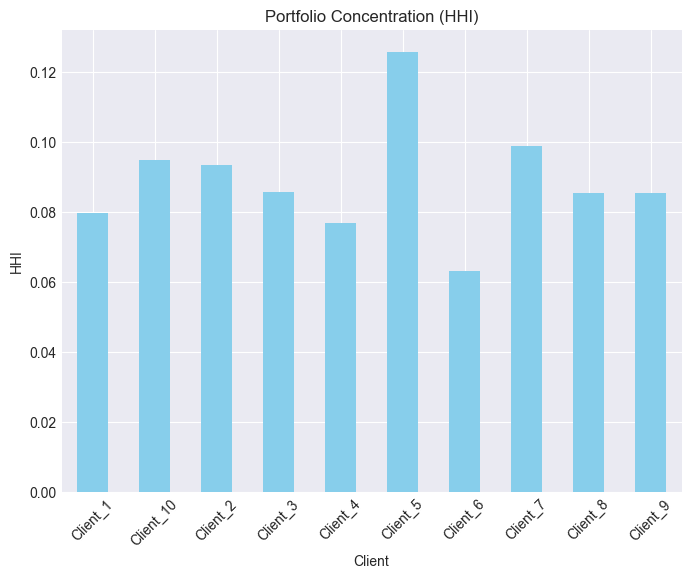

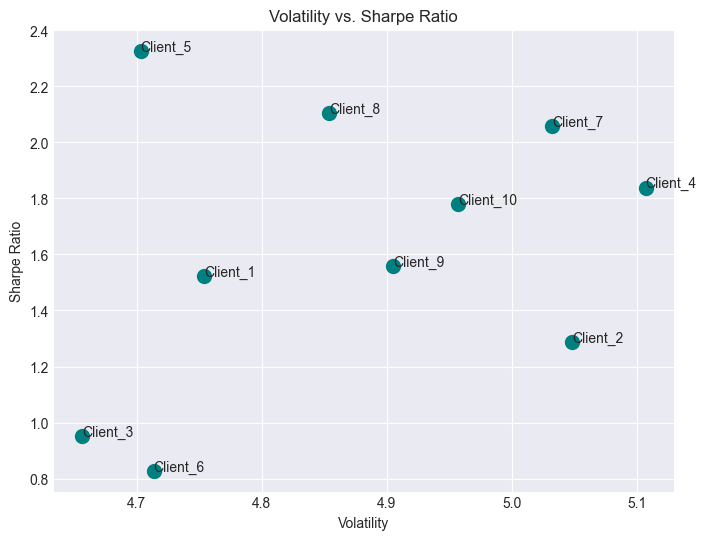

In [53]:
plt.style.use('seaborn-v0_8-darkgrid')

# 1. Cumulative Returns Line Chart
plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title('Cumulative Returns by Client')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 2. Monthly Returns Bar Chart
plt.figure(figsize=(10, 6))
monthly_returns.plot(kind='bar')
plt.title('Monthly Returns by Client')
plt.xlabel('Month-End')
plt.ylabel('Return')
plt.legend(title='Client', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

# 3. HHI Bar Chart
latest_hhi = concentration_df.groupby('Client')['HHI'].last()
plt.figure(figsize=(8, 6))
latest_hhi.plot(kind='bar', color='skyblue')
plt.title('Portfolio Concentration (HHI)')
plt.xlabel('Client')
plt.ylabel('HHI')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

# 5. Volatility vs. Sharpe Ratio Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(risk_metrics['Volatility'], risk_metrics['Sharpe Ratio'], s=100, c='teal')

for client in risk_metrics.index:
    plt.annotate(client, (risk_metrics.loc[client, 'Volatility'], risk_metrics.loc[client, 'Sharpe Ratio']))

plt.title('Volatility vs. Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()


/Users/mukundshrivas/ama_project/src/reporter.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = (1 + daily_returns).resample('M').prod() - 1


Report for Client_10 saved to /Users/mukundshrivas/ama_project/client_reports/client_report_Client_10.pdf


'/Users/mukundshrivas/ama_project/client_reports/client_report_Client_10.pdf'

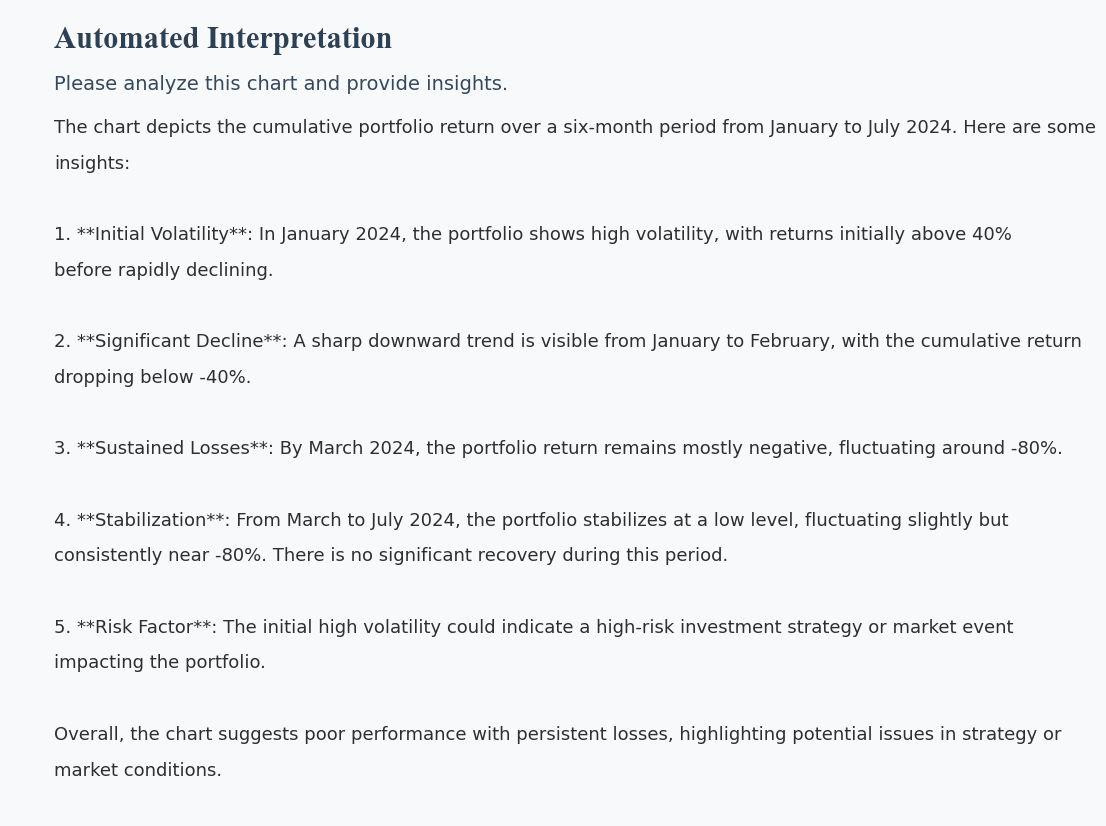

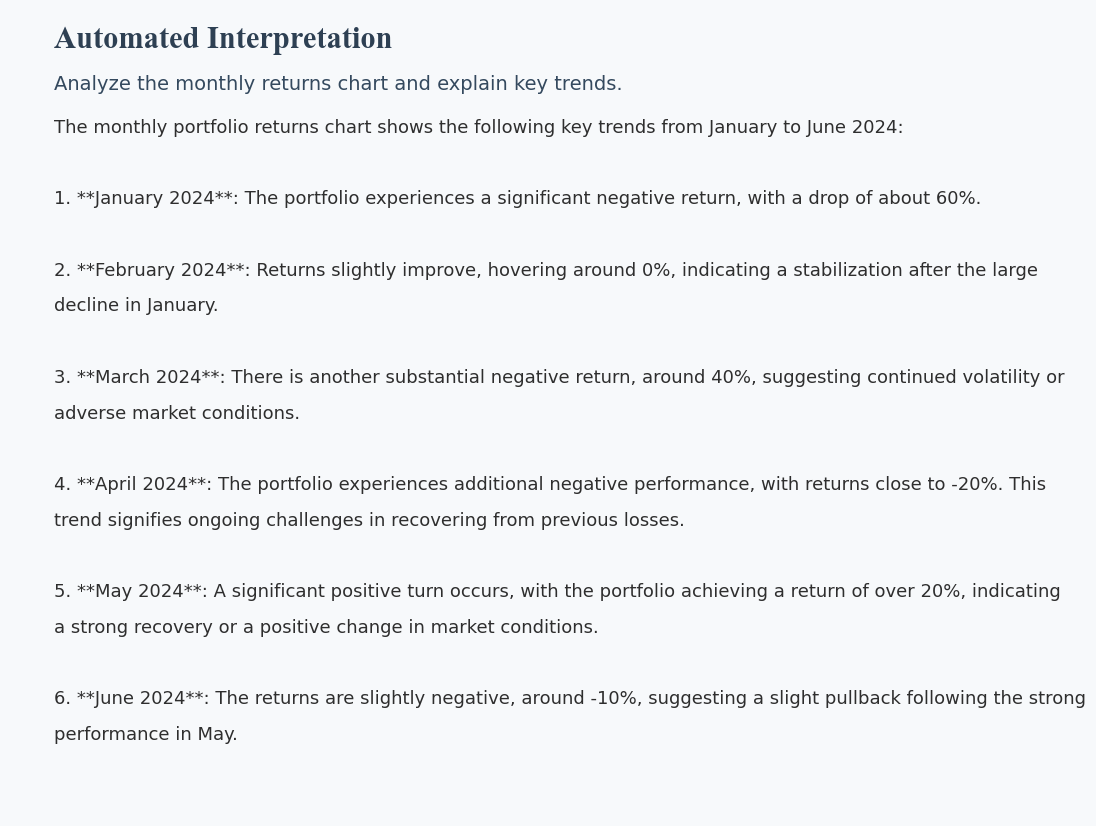

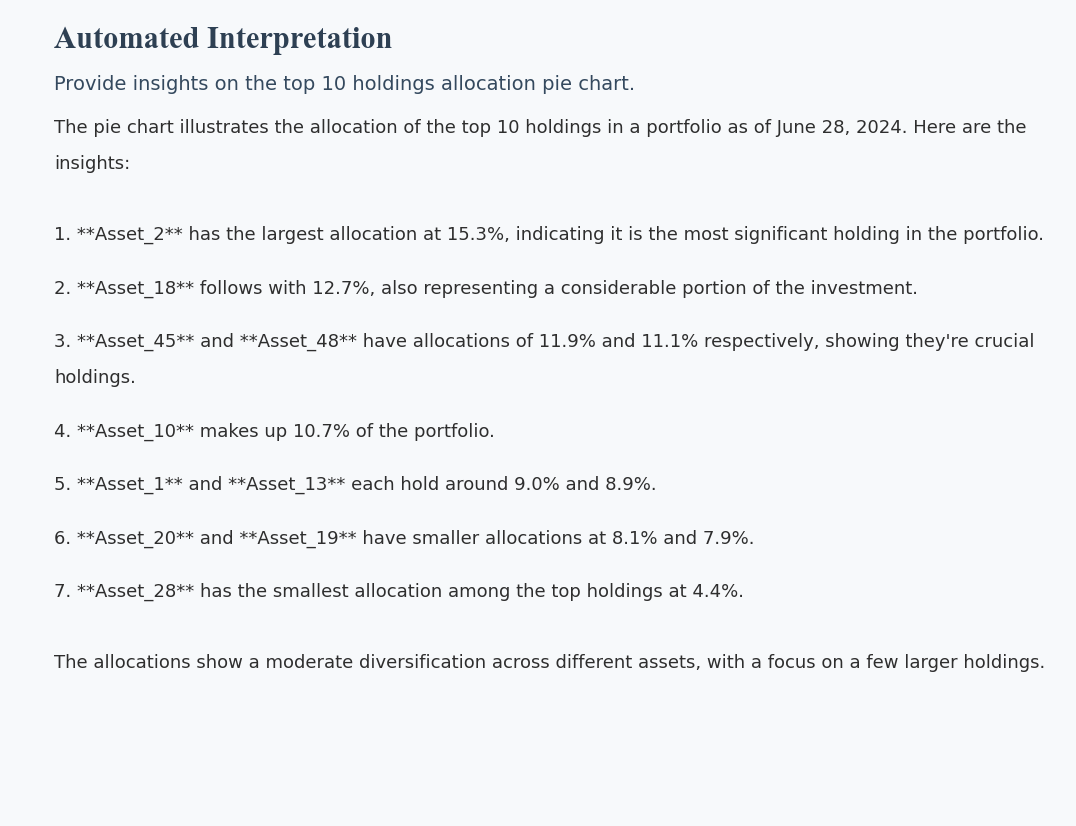

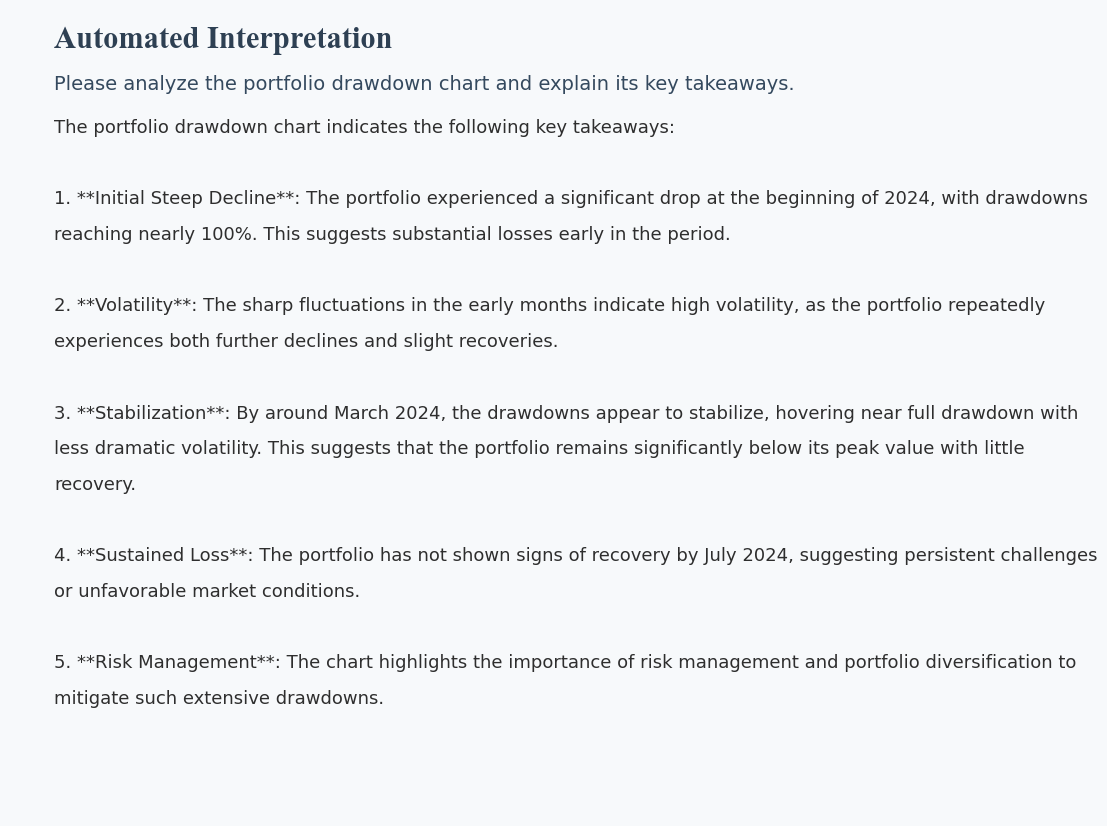

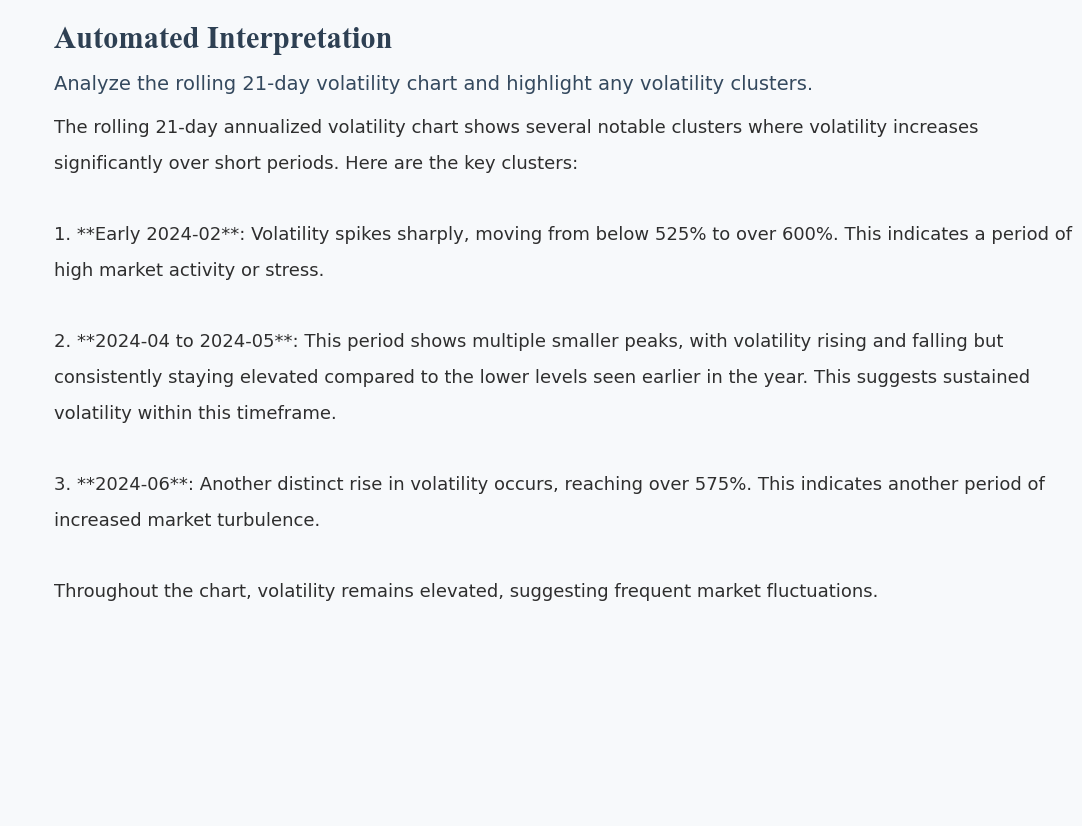

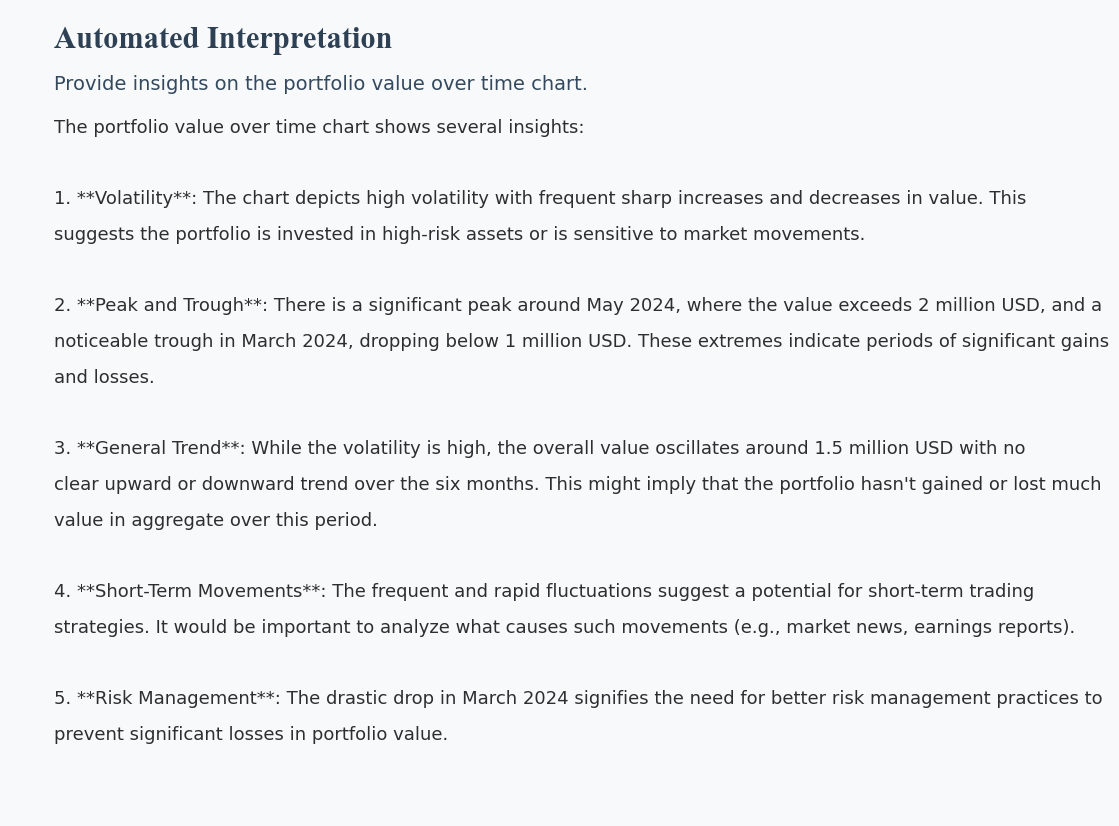

In [54]:
# Generating Client Reports
generate_client_report("Client_10", master, openai_api_key=api_key)

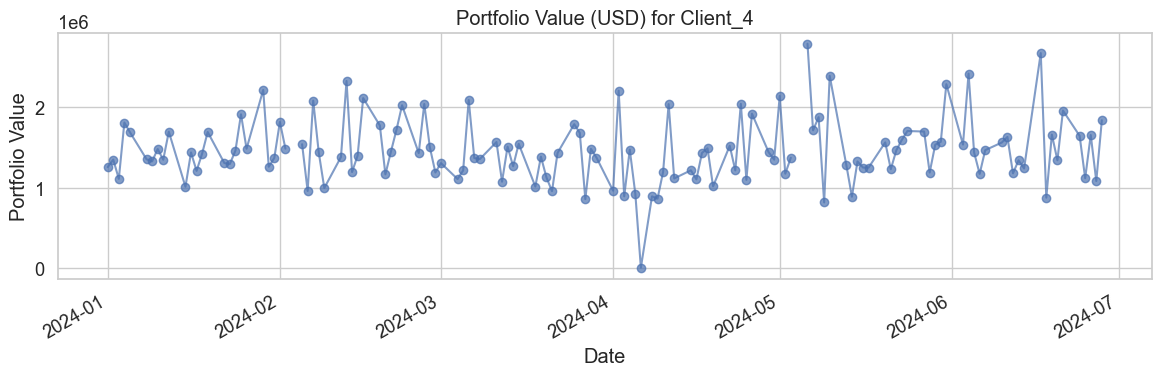

In [55]:
client = "Client_4"
portfolio_value_client = pivot_value[client]
plt.figure(figsize=(12,4))
portfolio_value_client.plot(marker='o', alpha=0.7)
plt.title(f"Portfolio Value (USD) for {client}")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.tight_layout()
plt.show()
